In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
# pth_out = os.path.join(pth, 'figures', 'modeling', 'attributions', 'CCCA')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'CCCA_malignant.h5ad'))
adata

AnnData object with n_obs × n_vars = 1434229 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores', 'post_op_gleason_score', 'margin

In [4]:
adata_dev = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata_dev

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [5]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn} #if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

    ig = adata_dev[:, g].layers['IG_z'].sum(axis = 1)
    adata_dev.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications
union


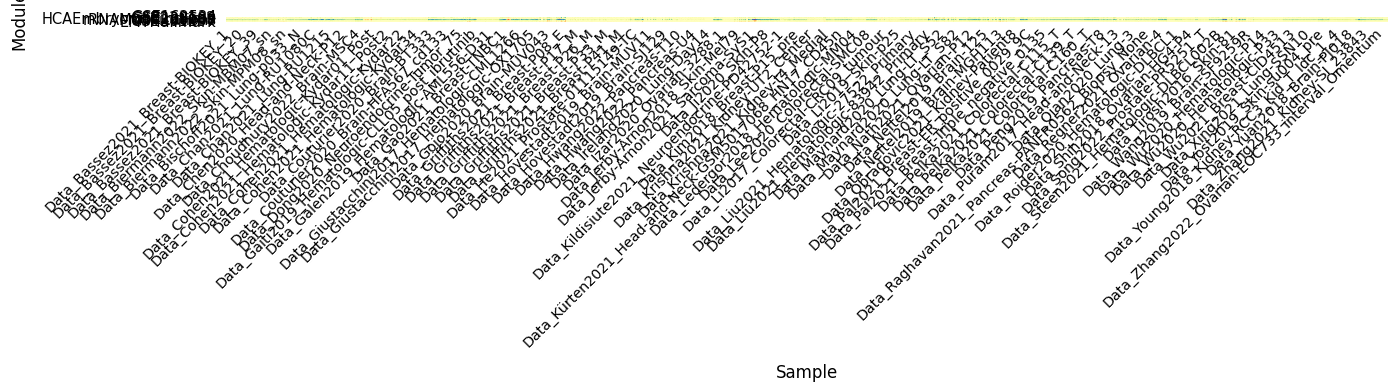

In [70]:
feat_plt = [
    'GSE162534',
    'GSE229103',
    'GSE136689',
    'HCAEmbryonicHindlimb',
    'rRNAModifications',
    'GSE201257',
    'EMTHallmark',
    'latent_z']

df_plt = adata_dev.obs.groupby(['source', 'celltype'], observed = True)[feat_plt].mean().T
df_plt_ = adata.obs.groupby(['Name', 'sample'], observed = True)[feat_plt].mean().T
# df_plt = df_plt.div(df_plt.abs().sum(axis = 0), axis = 1)
# df_plt_ = df_plt_.loc[:, df_plt_.T.latent_z > .5]

# df_plt_.columns.get_level_values(0)

# src, _max_ = df_plt.idxmax(), df_plt.max()
# order = pd.concat({'src' : src, 'max' : _max_}, axis = 1).reset_index()
# order['src'] = pd.Categorical(order.src, feat_plt, ordered = True)
# order = order.sort_values(['max'], ascending = [False])
# df_plt = df_plt.loc[:, order.Category]

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
# df_plt.index = df.loc[df_plt.index].Name
hm = sns.heatmap(
    df_plt_.iloc[:-1],
    cmap = 'Spectral_r',
    center = 0,
    # cmap = 'copper',
    # vmin = 0,
    # vmax = .05,
    square = True,
    cbar = False,
    ax = ax)

ax.set_xlabel('Sample', size = 12, labelpad = 10)
ax.set_ylabel('Module', size = 12, labelpad = 10)
ax.tick_params(size = 0, pad = 7, labelsize = 10.5)
ax.set_xticklabels(ax.get_xticklabels(),
                   size = 10.25, rotation = 45,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
ax.tick_params(axis = 'x', pad = 6)
# fn = os.path.join(pth_out, 'carcinomas.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()

<Axes: ylabel='HCAEmbryonicHindlimb'>

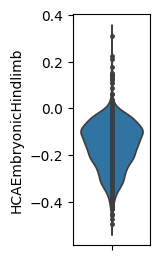

In [71]:
plt.figure(figsize = (1, 3))
sns.violinplot(df_plt_.T, y = 'HCAEmbryonicHindlimb', inner = 'point')
# plt.axhline(.5)

In [ ]:
# feat_plt = [
#     'GSE162534',
#     'GSE229103',
#     'GSE136689',
#     'HCAEmbryonicHindlimb',
#     'rRNAModifications',
#     'GSE201257',
#     'EMTHallmark']

# msk = (adata.obs.Category == 'Skin')
# df_plt = adata[msk].obs.groupby('Disease')[feat_plt].mean().T
# df_plt = df_plt.div(df_plt.abs().sum(axis = 0), axis = 1)

# # src, _max_ = df_plt.idxmax(), df_plt.max()
# # order = pd.concat({'src' : src, 'max' : _max_}, axis = 1).reset_index()
# # order['src'] = pd.Categorical(order.src, feat_plt, ordered = True)
# # order = order.sort_values(['max'], ascending = [False])
# # df_plt = df_plt.loc[:, order.Disease]

# fig, ax = plt.subplots(1, 1, figsize = (2, 5))
# df_plt.index = df.loc[df_plt.index].Name
# hm = sns.heatmap(
#     df_plt,
#     cmap = 'copper',
#     vmin = 0,
#     # vmax = .05,
#     square = True,
#     cbar = False,
#     ax = ax)

# ax.set_xlabel('Sample', size = 12, labelpad = 10)
# ax.set_ylabel('Module', size = 12, labelpad = 10)
# ax.tick_params(size = 0, pad = 7, labelsize = 10.5)
# ax.set_xticklabels(ax.get_xticklabels(),
#                    size = 10.25, rotation = 45,
#                    rotation_mode = 'anchor',
#                    ha = 'right', va = 'center')
# ax.tick_params(axis = 'x', pad = 6)
# # fn = os.path.join(pth_out, 'carcinomas.pdf')
# # plt.savefig(fn, bbox_inches = 'tight')
# plt.show()

In [ ]:
# feat_plt = [
#     'GSE162534',
#     'GSE229103',
#     'GSE136689',
#     'HCAEmbryonicHindlimb',
#     'rRNAModifications',
#     'GSE201257',
#     'EMTHallmark']

# # msk = (adata.obs.Disease == 'High-Grade Serous Ovarian Cancer')
# df_plt = adata.obs.groupby('sample')[feat_plt].mean()#.T
# # df_plt = df_plt.div(df_plt.abs().sum(axis = 0), axis = 1)

# # # src, _max_ = df_plt.idxmax(), df_plt.max()
# # # order = pd.concat({'src' : src, 'max' : _max_}, axis = 1).reset_index()
# # # order['src'] = pd.Categorical(order.src, feat_plt, ordered = True)
# # # order = order.sort_values(['max'], ascending = [False])
# # # df_plt = df_plt.loc[:, order.Disease]

# fig, ax = plt.subplots(1, 1, figsize = (15, 5))
# # df_plt.index = df.loc[df_plt.index].Name
# hm = sns.heatmap(
#     df_plt,
#     cmap = 'RdBu_r',
#     center = 0,
#     # cmap = 'copper',
#     # vmin = 0,
#     # vmax = .05,
#     square = True,
#     # cbar = False,
#     ax = ax)

# ax.set_xlabel('Sample', size = 12, labelpad = 10)
# ax.set_ylabel('Module', size = 12, labelpad = 10)
# ax.tick_params(size = 0, pad = 7, labelsize = 10.5)
# ax.set_xticklabels(ax.get_xticklabels(),
#                    size = 10.25, rotation = 45,
#                    rotation_mode = 'anchor',
#                    ha = 'right', va = 'center')
# ax.tick_params(axis = 'x', pad = 6)
# # fn = os.path.join(pth_out, 'carcinomas.pdf')
# # plt.savefig(fn, bbox_inches = 'tight')
# plt.show()

In [ ]:
# feat_plt = [
#     'GSE162534',
#     'GSE229103',
#     'GSE136689',
#     'HCAEmbryonicHindlimb',
#     'rRNAModifications',
#     'GSE201257',
#     'EMTHallmark']

# msk = (adata.obs.Category == 'Pancreas')
# df_plt = adata[msk].obs.groupby('sample')[feat_plt].mean().T
# # df_plt = df_plt.div(df_plt.abs().sum(axis = 0), axis = 1)

# # src, _max_ = df_plt.idxmax(), df_plt.max()
# # order = pd.concat({'src' : src, 'max' : _max_}, axis = 1).reset_index()
# # order['src'] = pd.Categorical(order.src, feat_plt, ordered = True)
# # order = order.sort_values(['max'], ascending = [False])
# # df_plt = df_plt.loc[:, order.Title]

# fig, ax = plt.subplots(1, 1, figsize = (20, 5))
# df_plt.index = df.loc[df_plt.index].Name
# hm = sns.heatmap(
#     df_plt,
#     cmap = 'RdBu_r',
#     center = 0,
#     # cmap = 'copper',
#     # vmin = 0,
#     # vmax = .05,
#     square = True,
#     cbar = False,
#     ax = ax)

# ax.set_xlabel('Sample', size = 12, labelpad = 10)
# ax.set_ylabel('Module', size = 12, labelpad = 10)
# ax.tick_params(size = 0, pad = 7, labelsize = 10.5)
# ax.set_xticklabels(ax.get_xticklabels(),
#                    size = 10.25, rotation = 45,
#                    rotation_mode = 'anchor',
#                    ha = 'right', va = 'center')
# ax.tick_params(axis = 'x', pad = 6)
# # fn = os.path.join(pth_out, 'carcinomas.pdf')
# # plt.savefig(fn, bbox_inches = 'tight')
# plt.show()